In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 24.2 MB/s 
     |████████████████████████████████| 498.0 MB 11 kB/s 
     |████████████████████████████████| 5.8 MB 71.2 MB/s 
     |████████████████████████████████| 462 kB 69.9 MB/s 
     |████████████████████████████████| 1.4 MB 62.5 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.4 MB 18.6 MB/s 
     |████████████████████████████████| 352 kB 61.7 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 662 kB 58.3 MB/s 
     |████████████████████████████████| 1.3 MB 52.2 MB/s 
     |████████████████████████████████| 118 kB 56.5 MB/s 
     |████████████████████████████████| 1.1 MB 62.4 MB/s 
     |████████████████████████████████| 2.3 MB 52.1 MB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 5.8 MB 60.3 MB/s 
     |████████████████████████████████| 238 kB 74.5 MB/s 
     |████████████████████████████████| 6.0 MB 62.7 MB/s 
     |████████████████████████████████| 1.7 MB 61.2 MB/s 
     |████████████████████████████████| 439 kB 70.3 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Parametri BERT

In [6]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
tfhub_handle_encoder =  'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
gs_folder_bert = 'gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12'
bert_vocab = os.path.join(gs_folder_bert, 'vocab.txt')

print('BERT model selected                : ', tfhub_handle_encoder)
print('Preprocessing model auto-selected  : ', tfhub_handle_preprocess)
print('BERT vocab                         : ', bert_vocab)

BERT model selected                :  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected  :  https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
BERT vocab                         :  gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12/vocab.txt


### Variabili Globali

In [7]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_bert'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_bert'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
en_vocab_finalname = 'en_vocab_custom.txt'
it_vocab_finalname = 'it_vocab_custom.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
en_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, en_vocab_finalname))
it_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, it_vocab_finalname))

In [8]:
# parametri per il modello
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'

# parametri per il modello
NUM_SAMPLES = 300000 
TRAIN = 18016
VALIDATION = 6016
TEST = 100

MAX_VOCAB_SIZE = 20000 
EMBEDDING_DIM = 64 
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 64

NUM_LAYERS = 1 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 20

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## DATASET

### Caricamento Dati

In [9]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

df = df[-(TRAIN+VALIDATION+TEST):].reset_index(drop=True)

# Mischio il dataset in modo che sia più uniforme tra train e test
df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

print(df.iloc[-4:], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

validation_input_data = input_data[TRAIN:TRAIN+VALIDATION]
validation_target_data = target_data[TRAIN:TRAIN+VALIDATION]

test_input_data = input_data[TRAIN+VALIDATION:]
test_target_data = target_data[TRAIN+VALIDATION:]

print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------VALIDATION SET---------------')
print(validation_input_data[-4:])
print(validation_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])

                                      input  \
24128  We're running a bit behind schedule.   
24129   Do you really think it's necessary?   
24130    I have to tell Tom and the others.   
24131    Tom doesn't seem to be very tired.   

                                     target  
24128     Noi siamo leggermente in ritardo.  
24129  Tu pensi davvero che sia necessaria?  
24130     Io devo dirlo a Tom e agli altri.  
24131   Tom non sembra essere molto stanco.   

-----------TRAIN SET--------------
['Tom was thinking of going to Boston.', 'We measured the depth of the river.', "Don't interrupt me when I'm talking.", 'Are you a senior high school student?']
['Tom stava pensando di andare a Boston.', 'Abbiamo misurato la profondità del fiume.', 'Non mi interrompete quando sto parlando.', 'Sei uno studente delle superiori?']
-----------VALIDATION SET---------------
['Wake me up early tomorrow morning.', "I don't need to tell you anything.", "I'm three years younger than he is.", "Who's you

### Analisi Dati

In [10]:
print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Train        : {min(train_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Train       : {min(train_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Train        : {max(train_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Train       : {max(train_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Validation   : {min(validation_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Validation  : {min(validation_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Validation   : {max(validation_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Validation  : {max(validation_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Test         : {min(test_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Test        : {min(test_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Test         : {max(test_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Test        : {max(test_target_data, key = len)}')

Esempi nel Dataset di Train                            : 18016
Frase più corta in inglese nel Dataset di Train        : Are you in a hurry? "Not really."
Frase più corta in italiano nel Dataset di Train       : La aspetterò.
Frase più lunga in inglese nel Dataset di Train        : A group of gangsters stole the money.
Frase più lunga in italiano nel Dataset di Train       : Per gli adulti la tariffa generale di ammissione è di sette dollari.
---------------------------------------------------------------------------------------
Esempi nel Dataset di Validation                       : 6016
Frase più corta in inglese nel Dataset di Validation   : What time is it now? "It's 2:30."
Frase più corta in italiano nel Dataset di Validation  : Ti aspetterò.
Frase più lunga in inglese nel Dataset di Validation   : Can you tell the Jackson twins apart?
Frase più lunga in italiano nel Dataset di Validation  : Per favore, non fare bollire le uova fino a farle diventare così dure.
-------------------

## Tokenizer

Carico il modello di tokenizer di BERT e creo un Tokenizer per il set di dati a disposizione

### Tokenizer Bert

In [11]:
# Tokenizer BERT
tokenizer_encoder = hub.KerasLayer(tfhub_handle_preprocess, name='Bert_Preprocessing')

### Tokenizer Custom

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_en = dataset.map(lambda en, it: en)
train_it = dataset.map(lambda en, it: it)

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [13]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [14]:
exist_vocab = Path(en_vocab_filenamepath)

if not exist_vocab.exists():
  en_vocab = bert_vocab.bert_vocab_from_dataset(
      train_en.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(en_vocab_filenamepath, en_vocab)

In [15]:
exist_vocab = Path(it_vocab_filenamepath)

if not exist_vocab.exists():
  it_vocab = bert_vocab.bert_vocab_from_dataset(
      train_it.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(it_vocab_filenamepath, it_vocab)

In [16]:
en_tokenizer = text.BertTokenizer(en_vocab_filenamepath, **bert_tokenizer_params)
it_tokenizer = text.BertTokenizer(it_vocab_filenamepath, **bert_tokenizer_params)

In [17]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  x = tf.concat([starts, ragged, ends], axis=1)
  # x = keras.preprocessing.sequence.pad_sequences(x.numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')
  return x

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

#### Classe Tokenizer Custom

In [18]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [19]:
tokenizers = tf.Module()
tokenizers.en = CustomTokenizer(reserved_tokens, en_vocab_filenamepath)
tokenizers.it = CustomTokenizer(reserved_tokens, it_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [20]:
print(f'Vocabolario Italiano : {tokenizers.it.get_vocab_size()}')

Vocabolario Italiano : 2179


In [21]:
print(input_data[-2:])
print(tokenizer_encoder(input_data[-2:])['input_word_ids'][:, :16])
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.it.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.it.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')[:, :16])

['I have to tell Tom and the others.', "Tom doesn't seem to be very tired."]
tf.Tensor(
[[ 101 1045 2031 2000 2425 3419 1998 1996 2500 1012  102    0    0    0
     0    0]
 [ 101 3419 2987 1005 1056 4025 2000 2022 2200 5458 1012  102    0    0
     0    0]], shape=(2, 16), dtype=int32)
------------------------------------------------------------------
['Io devo dirlo a Tom e agli altri.', 'Tom non sembra essere molto stanco.']
<tf.RaggedTensor [[2, 60, 205, 1202, 24, 52, 28, 1509, 796, 11, 3],
 [2, 52, 53, 160, 81, 71, 391, 11, 3]]>
[[   2   60  205 1202   24   52   28 1509  796   11    3    0    0    0
     0    0]
 [   2   52   53  160   81   71  391   11    3    0    0    0    0    0
     0    0]]


In [22]:
print([min(train_input_data, key = len)])
print(tokenizer_encoder([min(train_input_data, key = len)])['input_word_ids'][:, :16])
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.en.tokenize([min(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([min(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')[:, :16])

['Are you in a hurry? "Not really."']
tf.Tensor(
[[ 101 2024 2017 1999 1037 9241 1029 1000 2025 2428 1012 1000  102    0
     0    0]], shape=(1, 16), dtype=int32)
------------------------------------------------------------------
['La aspetterò.']
<tf.RaggedTensor [[2, 35, 294, 114, 748, 614, 581, 381, 11, 3]]>
[[  2  35 294 114 748 614 581 381  11   3   0   0   0   0   0   0]]


In [23]:
print([min(train_input_data, key = len)])
print(tokenizer_encoder([max(train_input_data, key = len)])['input_word_ids'][:, :16])
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.en.tokenize([max(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([max(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')[:, :40])

['Are you in a hurry? "Not really."']
tf.Tensor(
[[  101  1037  2177  1997 20067  2015 10312  1996  2769  1012   102     0
      0     0     0     0]], shape=(1, 16), dtype=int32)
------------------------------------------------------------------
['Per gli adulti la tariffa generale di ammissione è di sette dollari.']
<tf.RaggedTensor [[2, 39, 166, 30, 812, 537, 24, 149, 1725, 1405, 537, 35, 294, 43, 569,
  537, 684, 684, 294, 30, 510, 166, 297, 173, 27, 537, 206, 528, 537, 794,
  328, 173, 28, 27, 537, 1466, 1621, 57, 1504, 569, 537, 11, 3]]>
[[   2   39  166   30  812  537   24  149 1725 1405  537   35  294   43
   569  537  684  684  294   30  510  166  297  173   27  537  206  528
   537  794  328  173   28   27  537 1466 1621   57 1504  569]]


## Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [24]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizer_encoder(en)          

  # Tokenizzo l'input per il Decder e creo la variabile Target
  it = tokenizers.it.tokenize(it)
  decoder = it[:, :-1].to_tensor()  # Drop the [END] tokens
  target = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (encoder, decoder), target

In [25]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [26]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_data, validation_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = make_batches(validation_dataset)

In [27]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (enc_input, dec_input), target in train_dataset.take(1):
  print('----------------------- ENCODER  -------------------------------')
  print(f'Shape                    : {enc_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {enc_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {enc_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print(f'Type Ids                 : {enc_input["input_type_ids"][0, :MAX_SEQ_LENGTH]}')  
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0]}')  
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0]}')  

----------------------- ENCODER  -------------------------------
Shape                    : (32, 128)
Word Ids                 : [ 101 1045 2123 1005 1056 2272 2067 2182 2200 2411 1012  102    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask               : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--------------------- DECODER ----------------------------------
Shape it input           : (32, 64)
Example it input         : [   2   60   53 1933   94   71  332   11    0    0    0    0    0    0
    0    0    0    0    0    0

## Encoder BERT

Predispondo la classe necessaria per la costruzione di BERT


In [28]:
class EncoderBert(layers.Layer):
  def __init__(self, bert_encoder, embedding_dim, max_len):
    super(EncoderBert, self).__init__()
    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder')
    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.max_len = max_len

  def call(self, x, debug=False):
    # x = self.preprocess(input_sequnces)

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :self.max_len]}')
      print(f'Input Mask                   : {x["input_mask"][0, :self.max_len]}')
      print(f'Type Ids                     : {x["input_type_ids"][0, :self.max_len]}')
      
    # x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    x = self.encoder(x)['encoder_outputs'] 
    x = x[int(len(x) / 2) - 1]

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :self.max_len]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    x = self.lambda_layer(x)
    if debug:
      print(f'Sequence Lambda Layer        : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :self.max_len]}')      
      print('*********************************************************') 

    return x

In [29]:
encoder_bert = EncoderBert(tfhub_handle_encoder, 
                           EMBEDDING_DIM, 
                           MAX_SEQ_LENGTH)

bert_outputs = encoder_bert(enc_input, debug) 

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101 1045 2123 1005 1056 2272 2067 2182 2200 2411 1012  102    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[ 0.22106194 -0.96542096 -0.37428582 -0.627242

## Decoder

Predispondo la classe necessaria per la costruzione di un Layer di Decoder

### TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras. 

In [30]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [31]:
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.it.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_it(dec_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************


### LAYER DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

#### DecodeBert

Implmentazione di un blocco di  decodifica custom per decodificare l'output dal layer EncoderBert prima di passarlo al Decoder del Transformer tramite estensione della classe Layer di Keras

In [32]:
class DecodeBert(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DecodeBert'):
    super(DecodeBert, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, training=False, debug=False):
    attn_output = self.att(query=bert_outputs,
                           value=bert_outputs, 
                           key=bert_outputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(bert_outputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG DECODE-BERT *********************')
      print(f'Shape Input Layer Decode-Bert       : {bert_outputs.shape}')
      print(f'Shape Output Layer Decode-Bert      : {output.shape}')
      print('*********************************************************')

    return output

In [33]:
encoder = DecodeBert(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(bert_outputs=bert_outputs,
                          training=training, 
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************


#### Layer Decoder

In [34]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.decode_bert = DecodeBert(max_len=max_len, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, bert_outputs, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    dec_bert = self.decode_bert(bert_outputs=bert_outputs, training=training, debug=debug)

    attn_output2 = self.att2(key=dec_bert, 
                             value=dec_bert, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [39]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          bert_outputs=bert_outputs,  
                          training=training,
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Outputs Decoder             : (32, 64, 64)
*********************************************************


## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras.

In [36]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               vocab_size,
               tfhub_handle_encoder,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)

    self.encoder = EncoderBert(tfhub_handle_encoder, embed_dim, max_len)
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder(inputs_encoder, debug) 

    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder["input_word_ids"].shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    transformer_output = inputs_decoder
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           bert_outputs=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [37]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.it.get_vocab_size(),
                               tfhub_handle_encoder,
                               DROPUOT)

transformer_output = transformer((enc_input, dec_input), 
                                 training=training,
                                 debug=debug)

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101 1045 2123 1005 1056 2272 2067 2182 2200 2411 1012  102    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[ 0.22106194 -0.96542096 -0.37428582 -0.627242

In [38]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 143552    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_bert_1 (EncoderBert  multiple                 109695553 
 )                                                               
                                                                 
 DEC (Decoder)               multiple                  402912    
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  141635    
                                                 

### Addestramento modello con ottimizzatore ADAM

### Compilazione

In [40]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                       beta_1=BETA_1, 
                                       beta_2=BETA_2),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [41]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

### Addestramento

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/20
563/563 [==============================] - 651s 1s/step - loss: 3.7819 - sparse_categorical_accuracy: 0.7962 - val_loss: 1.3195 - val_sparse_categorical_accuracy: 0.8337
Epoch 2/20
563/563 [==============================] - 644s 1s/step - loss: 1.1354 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.9239 - val_sparse_categorical_accuracy: 0.8665
Epoch 3/20
563/563 [==============================] - 628s 1s/step - loss: 0.9215 - sparse_categorical_accuracy: 0.8682 - val_loss: 0.8379 - val_sparse_categorical_accuracy: 0.8738
Epoch 4/20
563/563 [==============================] - 622s 1s/step - loss: 0.8448 - sparse_categorical_accuracy: 0.8744 - val_loss: 0.7819 - val_sparse_categorical_accuracy: 0.8807
Epoch 5/20
563/563 [==============================] - 637s 1s/step - loss: 0.7910 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.7373 - val_sparse_categorical_accuracy: 0.8845
Epoch 6/20
563/563 [==============================] - 636s 1s/step - loss: 0.7506 - sparse_cate

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

KeyError: ignored

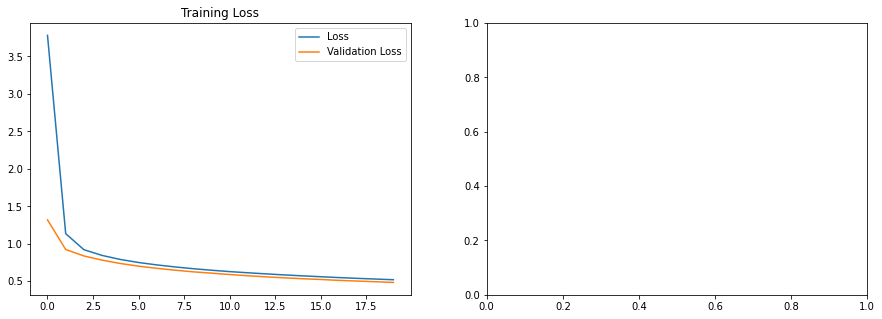

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Addestramento 2

In [42]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          initial_epoch=EPOCHS_ADAM,
                          epochs=EPOCHS_ADAM+EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 21/40
563/563 [==============================] - 629s 1s/step - loss: 0.5231 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.4435 - val_sparse_categorical_accuracy: 0.9127
Epoch 22/40
563/563 [==============================] - 631s 1s/step - loss: 0.5120 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.4374 - val_sparse_categorical_accuracy: 0.9135
Epoch 23/40
563/563 [==============================] - 611s 1s/step - loss: 0.5043 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.4313 - val_sparse_categorical_accuracy: 0.9143
Epoch 24/40
563/563 [==============================] - 627s 1s/step - loss: 0.4967 - sparse_categorical_accuracy: 0.9059 - val_loss: 0.4266 - val_sparse_categorical_accuracy: 0.9150
Epoch 25/40
563/563 [==============================] - 627s 1s/step - loss: 0.4892 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.4203 - val_sparse_categorical_accuracy: 0.9156
Epoch 26/40
563/563 [==============================] - 627s 1s/step - loss: 0.4817 - spars

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
class Translate:
  def __init__(self, transformer_block, tokenizers, tokenizer_bert):
    self.transformer = transformer_block
    self.tokenizers = tokenizers
    self.tokenizer_bert = tokenizer_bert

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    inputs_bert = self.tokenizer_bert(input_text)

    start_end = self.tokenizers.it.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      
      transformer_output = transformer([inputs_bert, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.it.detokenize(output)[0]  

    tokens = tokenizers.it.lookup(output)[0]

    return text, tokens

In [ ]:
test_sequences = [test_input_data[41], test_input_data[30], test_input_data[10], 
                  test_input_data[57], test_input_data[82], test_input_data[15], 
                  test_input_data[4], test_input_data[42]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers,
                      tokenizer_bert=tokenizer_encoder)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  # print(f'tokens : {token}')
  # print(target_data[41])
  # break
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[30])
print(test_target_data[10])
print(test_target_data[57])
print(test_target_data[82])
print(test_target_data[15])
print(test_target_data[4])
print(test_target_data[42])

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720